In [1]:
import jax
import jax.numpy as jnp
from jax import random, jvp, grad, lax

from jax_rb.manifolds.se_left_invariant import SELeftInvariant

import jax_rb.simulation.simulator as sim
import jax_rb.simulation.matrix_group_integrator as mi
from jax_rb.utils.utils import (grand, sym, rand_positive_definite)
jax.config.update('jax_default_device', jax.devices('cpu')[0])
jax.config.update("jax_enable_x64", True)

In [2]:
import itertools
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.core.display import HTML
rc('animation', html='jshtml')
# matplotlib.use("AGG")

In [5]:
def make_brownian(mnf, key, n_dim, n_f, lin_comb, scale, n_pnts):
    """ return one single path
    fori is slower for small n_pnts but fast for large n_pnts
    """
    x_0, key = grand(key, (n_dim, n_f))

    if not (lin_comb is None):
        x_0 = x_0.at[:, n_dim+1:n_f].set(x_0[:, :n_dim+1]@lin_comb)
    x_arr = jnp.zeros((n_pnts, n_dim*n_f))
    x_arr = x_arr.at[0, :].set(10.*x_0.reshape(-1))
    seq, _ = grand(key, ((n_dim+1)**2, n_pnts))

    def body_fun(i, val):
        g = mi.geodesic_move(mnf, jnp.eye(n_dim+1), seq[:, i-1], scale)
        return val.at[i, :].set((g[:-1, :-1]@val[i-1, :].reshape(n_dim, n_f)
                                 + g[:-1, -1][:, None]).reshape(-1))

    x_arr = lax.fori_loop(1, n_pnts, body_fun, x_arr)
    return x_arr.reshape(n_pnts, n_dim, n_f)


Animation of $\mathsf{SE}(2)$

In [7]:
n_dim = 2
n_f = 5
plot_size = 10
colors = ["r", "b", "g", "m", "c"]

def func(num, x_arr, lines, dots):
    # ANIMATION FUNCTION
    for i in range(n_f):
        lines[i].set_data(x_arr[:num, :, i].T)
        if num > 1:
            dots[i].set_data(x_arr[num-2:num-1, :, i].T)
    return lines

key = random.PRNGKey(0)
se_dim = n_dim*(n_dim+1)//2
diag = jnp.ones(se_dim).at[0].set(plot_size/4)
se = SELeftInvariant(n_dim, jnp.diag(diag))
scale = .4

N = 200
lin_comb = jnp.array([[1/4, .5, 1/4]]).T
x_arr = make_brownian(se, key, n_dim, n_f, lin_comb, scale, N)
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure()
ax = plt.axes()
lines = [plt.plot(x_arr[:, 0, i], x_arr[:, 1, i],  c=colors[i])[0]
          for i in range(n_f)]  # For line plot

dots = [plt.plot(x_arr[:1, 0, i], x_arr[:1, 1, i],  c=colors[i], marker='o')[0]
          for i in range(n_f)]
ax.set_xlabel('X(t)')
ax.set_ylabel('Y(t)')
ax.set_title('Trajectory of a Riemannian Brownian motion son SE(2)')

# Creating the Animation object
line_ani = animation.FuncAnimation(
    fig, func, frames=N, fargs=(x_arr, lines, dots,), interval=200, blit=False)
line_ani.save('se2_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close()

HTML(line_ani.to_html5_video())

In [8]:
n_dim = 3
n_f = 4
plot_size = 10
colors = ["r", "b", "g", "m"]

def func(num, x_arr, lines, dots):
    # ANIMATION FUNCTION
    for i in range(n_f):
        lines[i].set_data(x_arr[:num, :2, i].T)  # cannot set 3d data, break to two commands
        lines[i].set_3d_properties(x_arr[:num, 2, i])
        if num > 1:
            dots[i].set_data(x_arr[num-2:num-1, :2, i].T)
            dots[i].set_3d_properties(x_arr[num-2:num-1, 2, i].T)
    return lines

# THE DATA POINTS
key = random.PRNGKey(0)
se_dim = n_dim*(n_dim+1)//2
# diag = jnp.ones(se_dim).at[2].set(plot_size/4).at[4].set(plot_size/4).at[5].set(plot_size/4)*10
diag = jnp.arange(1, se_dim+1)*10

se = SELeftInvariant(n_dim, jnp.diag(diag))
scale = .5

N = 200
x_arr = make_brownian(se, key, n_dim, n_f, None, scale, N)

# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure()
ax = plt.axes(projection='3d')
lines = [plt.plot(x_arr[:, 0, i], x_arr[:, 1, i],
                  x_arr[:, 2, i], c=colors[i])[0]
          for i in range(n_f)]  # For line plot

dots = [plt.plot(x_arr[:1, 0, i], x_arr[:1, 1, i],
                  x_arr[:1, 2, i],
                  c=colors[i], marker='o')[0]
          for i in range(n_f)]

ax.set_xlabel('X(t)')
ax.set_ylabel('Y(t)')
ax.set_zlabel('Z(t)')
ax.set_title('Trajectory of a Riemannian Brownian motion on SE(3)')

# Creating the Animation object
line_ani = animation.FuncAnimation(
    fig, func, frames=N, fargs=(x_arr, lines, dots), interval=50, blit=False)
line_ani.save('se3_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close()

HTML(line_ani.to_html5_video())

In [10]:
from jax_rb.manifolds import AffineLeftInvariant

rc('animation', html='jshtml')
n_dim = 2
n_f = 4
colors = ["r", "b", "m", "g"]

def func(num, x_arr, lines, dots):
    # ANIMATION FUNCTION
    for i in range(n_f):
        lines[i].set_data(x_arr[:num, :, i].T)  # cannot set 3d data, break to two commands
        if num > 0:
            dots[i].set_data(x_arr[num-2:num-1, :2, i].T)
    return lines

# THE DATA POINTS
key = random.PRNGKey(0)
af_dim = n_dim*(n_dim+1)
# diag = jnp.ones(se_dim).at[2].set(plot_size/4).at[4].set(plot_size/4).at[5].set(plot_size/4)
diag = jnp.arange(af_dim)*70. + 10

aff = AffineLeftInvariant(n_dim, jnp.diag(diag))
scale = .5

# lin_comb = jnp.array([[.25, .25, 0.25, .25], [1/2, .5, 0., 0.]]).T


N = 200
lin_comb = jnp.array([[1/2, .5, 0.]]).T
x_arr = make_brownian(aff, key, n_dim, n_f, lin_comb, scale, N)

# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure()
ax = plt.axes()
lines = [plt.plot(x_arr[:, 0, i], x_arr[:, 1, i],
                  c=colors[i])[0]
          for i in range(n_f)]  # For line plot

dots = [plt.plot(x_arr[:1, 0, i], x_arr[0, 1, i],
                  c=colors[i], marker='o')[0]
          for i in range(n_f)]

ax.set_xlabel('X(t)')
ax.set_ylabel('Y(t)')
ax.set_title('Trajectory of Riemannian Brownian motion Aff(2)')

# Creating the Animation object
line_ani = animation.FuncAnimation(
    fig, func, frames=N, fargs=(x_arr, lines, dots), interval=50, blit=False)
plt.close()
line_ani.save('af2_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

HTML(line_ani.to_html5_video())

In [8]:
n = 3
t_final = 3
n_path = 1000
n_div = 700
d_coeff = .5
dimsc = 1.
metric_mat, key = rand_positive_definite(key, se_dim, (.1, 30.))
mnf = SELeftInvariant(n, metric_mat)

stor = sim.Simulator(path_pay_off=lambda x, t: t*jnp.maximum(x[0, 0]-.5, 0),
                     final_pay_off=lambda x: x[0, 0]**2)

stor.run(lambda x, unit_move, scale: mi.geodesic_move(mnf, x, unit_move, scale),
         sim.RunParams(
            jnp.eye(n+1), key, t_final, n_path,
            n_div, d_coeff*dimsc,
            (n+1)**2, mnf.name(), False, f'geodesic_move'))

stor.run(lambda x, unit_move, scale: mi.rbrownian_ito_move(mnf, x, unit_move, scale),
         sim.RunParams(
            jnp.eye(n+1), key, t_final, n_path,
            n_div, d_coeff*dimsc,
            (n+1)**2, mnf.name(), False, f'ito_move'))

stor.run(lambda x, unit_move, scale: mi.rbrownian_stratonovich_move(mnf, x, unit_move, scale),
         sim.RunParams(
            jnp.eye(n+1), key, t_final, n_path,
            n_div, d_coeff*dimsc,
            (n+1)**2, mnf.name(), False, f'stratonovich_move'))

display([(jnp.nanmean(a[1]), a[0].run_type) for a in stor.runs])

[(Array(2.5737494, dtype=float64), 'geodesic_move'),
 (Array(2.57373077, dtype=float64), 'ito_move'),
 (Array(2.57314791, dtype=float64), 'stratonovich_move')]

In [9]:
n = 3
key = random.PRNGKey(0)
t_final = 100
n_path = 1000
n_div = 1000
d_coeff = .5
dimsc = 1.
metric_mat, key = rand_positive_definite(key, se_dim, (.1, 30.))
mnf = SELeftInvariant(n, metric_mat)

ustor = sim.Simulator(path_pay_off=None,
                     final_pay_off=lambda x: x[0, 0]**2)

ustor.run(lambda x, unit_move, scale: mi.geodesic_move(mnf, x, unit_move, scale),
         sim.RunParams(
            jnp.eye(n+1), key, t_final, n_path,
            n_div, d_coeff*dimsc,
            (n+1)**2, mnf.name(), False, f'geodesic_move'))

ustor.run(lambda x, unit_move, scale: mi.rbrownian_ito_move(mnf, x, unit_move, scale),
         sim.RunParams(
            jnp.eye(n+1), key, t_final, n_path,
            n_div, d_coeff*dimsc,
            (n+1)**2, mnf.name(), False, f'ito_move'))

ustor.run(lambda x, unit_move, scale: mi.rbrownian_stratonovich_move(mnf, x, unit_move, scale),
         sim.RunParams(
            jnp.eye(n+1), key, t_final, n_path,
            n_div, d_coeff*dimsc,
            (n+1)**2, mnf.name(), False, f'stratonovich_move'))
[(jnp.nanmean(a[1]), a[0].run_type) for a in ustor.runs]

[(Array(0.3304542, dtype=float64), 'geodesic_move'),
 (Array(0.33468244, dtype=float64), 'ito_move'),
 (Array(0.33573247, dtype=float64), 'stratonovich_move')]

In [10]:
def uniform_sample(key, shape, pay_off, n_samples):
    """ Sample the manifold uniformly. This works for quotient of SO(n)
    """
    x_all, key = grand(key, (shape[0], shape[1], n_samples))

    def do_one_point(seq):
        ei, ev = jnp.linalg.eigh(seq.T@seq)
        return pay_off(seq@ev@((1/jnp.sqrt(ei))[:, None]*ev.T))

    s = jax.vmap(do_one_point, in_axes=2)(x_all)
    return jnp.nanmean(s)

uniform_sample(key, (n, n), ustor.final_pay_off, n_path*1000)

Array(0.33330501, dtype=float64)

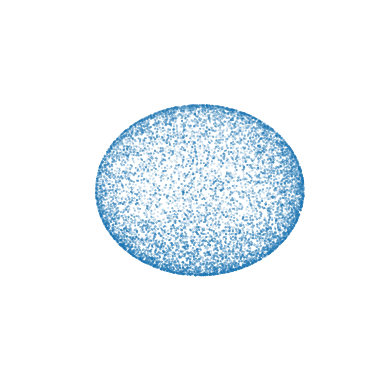

In [11]:
from jax.lax import fori_loop
import jax_rb.simulation.global_manifold_integrator as gmi
from jax_rb.manifolds import Sphere
n = 3
n_pnt = 10000
key = random.PRNGKey(0)
step = .1
# x_i = [jnp.zeros(n).at[-1].set(1.)]
x_i = jnp.zeros((n, n_pnt+1))
x_i = x_i.at[:, 0].set(jnp.zeros(n).at[-1].set(1.))
seq, _ = grand(key, (n, n_pnt))
sph = Sphere(n, 1.)
ax = plt.axes(projection='3d')

# for j in range(n_pnt):
#    x_i.append(gmi.geodesic_move_normalized(sph, x_i[-1], seq[:, j]/jnp.sqrt(jnp.sum(seq[:, j]**2)), step))
x_i= fori_loop(1, n_pnt+1,
              lambda i, val: val.at[:, i].set(gmi.geodesic_move_normalized(
                  sph, val[:, i-1], seq[:, i]/jnp.sqrt(jnp.sum(seq[:, i]**2)), step)), x_i)

# x_i = jnp.array(x_i).T
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')
ax.scatter3D(x_i[0, :], x_i[1, :], x_i[2, :], marker='o', s=.1)
